In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [36]:
from __future__ import unicode_literals

figsize(16, 10)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
fdg = np.loadtxt('/home/mabitbol/GBT-S140/externaldata/fd_G107_wim.dat')

In [6]:
cfs = fdg[:, 0] * 1.e9
mask = cfs < 4.e12
cfs = cfs[mask]
cjys = fdg[:, 1][mask]
cerrs = fdg[:, 2][mask]
cfit = fdg[:, 3][mask]
crem = fdg[:, 4][mask]
cremerr = fdg[:, 5][mask]

In [7]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9

In [8]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((0.16/60.)*pi/180.)**2

In [9]:
nfreqs = np.array([4.575, 5.625, 6.125]) * 1.e9
newdata = np.array([ 17.05, 17.66, 19.5])
nerrs = newdata * 0.2

In [10]:
bigfs = np.concatenate([cfs, nfreqs])
bigdata = np.concatenate([cjys, newdata])
bigerrs = np.concatenate([cerrs, nerrs])

In [11]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [12]:
def signal_b(freqs, EM, Asd, nup, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(freqs, A=Acmb)
    return fffit*beam, dustfit*beam, amefit*beam, ccmb*beam

In [13]:
def signal2(freqs, EM1, EM2, Ad, Bd, abeam, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [14]:
def signal2_b(freqs, EM1, EM2, Ad, Bd, abeam, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit, fffit2, dustfit, ccmb

In [15]:
def signal3(freqs, EM, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + ccmb) * beam

In [16]:
pn = np.array([200., 1.e-3, 20.e9, 80.e-5, 2., 30.e-6])
x = curve_fit(signal, cfs, cjys, p0=pn, sigma=cerrs, absolute_sigma=True)
pfit = x[0]

In [17]:
pn2 = np.array([145. , 1.e7, 50.e-5, 2., beam2, 30e-6])
y = curve_fit(signal2, cfs, cjys, p0=pn2, sigma=cerrs, absolute_sigma=True)
pfit2 = y[0]

In [18]:
pn3 = np.array([200., 80.e-5, 2., 30.e-6])
z = curve_fit(signal3, cfs, cjys, p0=pn3, sigma=cerrs, absolute_sigma=True)
pfit5 = z[0]

In [19]:
pn = np.array([200., 1.e-3, 20.e9, 80.e-5, 2., 30.e-6])
x = curve_fit(signal, bigfs, bigdata, p0=pn, sigma=bigerrs, absolute_sigma=True)
pfit3 = x[0]
cfit3 = x[1]

In [20]:
pn2 = np.array([145. , 1.e7, 50.e-5, 2., beam2, 30e-6])
y = curve_fit(signal2, bigfs, bigdata, p0=pn2, sigma=bigerrs, absolute_sigma=True)
pfit4 = y[0]
cfit4 = y[1]

In [21]:
rchisq1 = np.sum( ( cjys - signal(cfs, *pfit))**2 / cerrs**2 ) / (len(cjys) - 6.)
rchisq3 = np.sum( ( bigdata - signal(bigfs, *pfit3))**2 / bigerrs**2 ) / (len(bigdata) - 6.)

In [22]:
rchisq2 = np.sum( ( cjys - signal2(cfs, *pfit2))**2 / cerrs**2 ) / (len(cjys) - 6.)
rchisq4 = np.sum( ( bigdata - signal2(bigfs, *pfit4))**2 / bigerrs**2 ) / (len(bigdata) - 6.)

In [23]:
print rchisq1, rchisq3

0.145938297379 0.138268083448


In [24]:
print rchisq2, rchisq4

0.145126408559 0.174826860222


In [25]:
print "EM, Asd, nup, Ad, Bd, Acmb"
print pfit
print pfit3

EM, Asd, nup, Ad, Bd, Acmb
[  1.95631483e+02   1.18870094e-03   3.02116485e+10   7.46634098e-04
   2.01098950e+00   9.18555467e-05]
[  2.00949510e+02   1.17487281e-03   3.01361409e+10   7.47150575e-04
   2.01045939e+00   9.02241664e-05]


In [26]:
print "EM1, EM2, Ad, Bd, abeam, Acmb"
print pfit2
print pfit4

EM1, EM2, Ad, Bd, abeam, Acmb
[  1.53026684e+02   1.98478225e+07   7.98257804e-04   1.95826061e+00
   1.72547829e-08  -2.54521298e-05]
[  1.61821809e+02   6.18372317e+08   8.05263046e-04   1.95121200e+00
   5.98719260e-10  -3.95400901e-05]


In [27]:
np.sqrt(pfit2[-2] / pi) * 180. / pi * 60.

0.25477317315151071

In [28]:
np.sqrt(pfit4[-2] / pi) * 180. / pi * 60.

0.047458123384131093

In [29]:
print "EM, Asd, nup, Ad, Bd, Acmb"
print pfit3
print np.sqrt(np.diag(cfit3))

EM, Asd, nup, Ad, Bd, Acmb
[  2.00949510e+02   1.17487281e-03   3.01361409e+10   7.47150575e-04
   2.01045939e+00   9.02241664e-05]
[  2.20473986e+01   3.01203208e-04   3.19516813e+09   1.19298454e-04
   1.24009588e-01   3.99880766e-05]


In [30]:
print "EM1, EM2, Ad, Bd, abeam, Acmb"
print pfit4
print np.sqrt(np.diag(cfit4))

EM1, EM2, Ad, Bd, abeam, Acmb
[  1.61821809e+02   6.18372317e+08   8.05263046e-04   1.95121200e+00
   5.98719260e-10  -3.95400901e-05]
[  4.78069825e+01   6.29665003e+08   1.19599368e-04   1.18683297e-01
   6.05626182e-10   5.66669667e-05]


In [31]:
np.sqrt(np.sqrt(np.diag(cfit4)[-1]) / pi) * 180. / pi * 60.

14.600372275028159

In [32]:
ff0, dust0, ame0, cmb0 = signal_b(freqs, *pfit3)
ff1, ff2, dust2, cmb2 = signal2_b(freqs, *pfit4)

In [33]:
ff0a, dust0a, ame0a, cmb0a = signal_b(freqs, *pfit)
ff1a, ff2a, dust2a, cmb2a = signal2_b(freqs, *pfit2)

In [9]:
nfreqs = np.array([4.575, 5.625, 6.125]) * 1.e9
newdata = np.array([ 17.05, 17.66, 19.5])
nerrs = newdata * 0.2

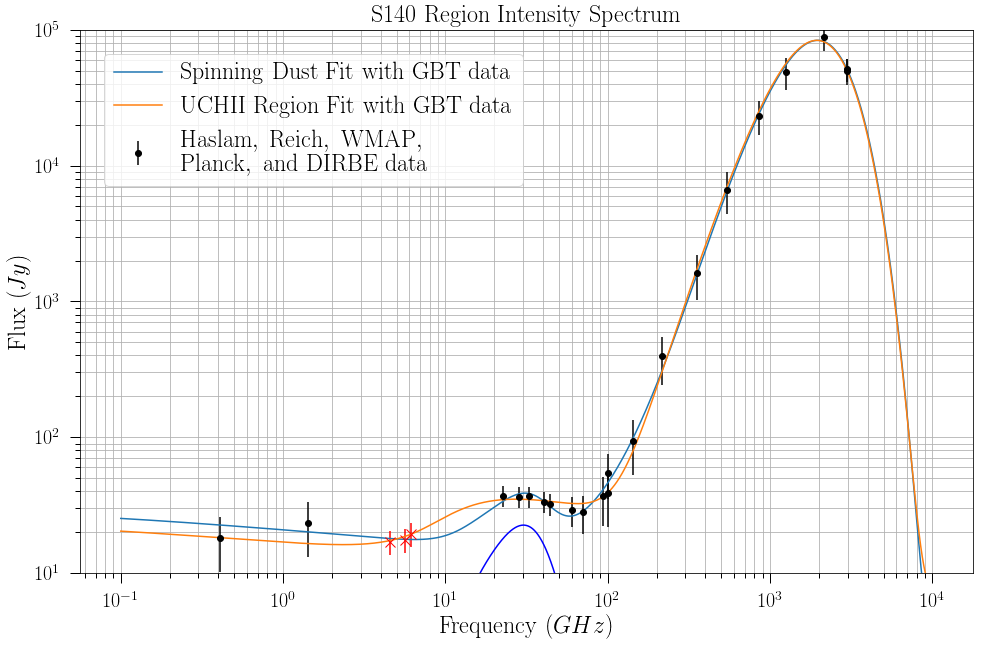

In [47]:
figure()
#plot(nu, signal(freqs, *pfit), label='$\mathrm{Spinning\ Dust\ without\ GBT\ data}$')
#plot(nu, signal2(freqs, *pfit2), label='$\mathrm{UCHII\ Region\ without\ GBT\ data}$')
plot(nu, signal(freqs, *pfit3), label='$\mathrm{Spinning\ Dust\ Fit\ with\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit4), label='$\mathrm{UCHII\ Region\ Fit\ with\ GBT\ data}$')
#errorbar(bigfs*1.e-9, bigdata, yerr=bigerrs, fmt='ko',\
#         label='$\mathrm{Haslam,\ Reich,\ GBT,}$\n$\mathrm{WMAP,\ Planck,\ and\ DIRBE\ data}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko',\
         label='$\mathrm{Haslam,\ Reich,\ WMAP,}$\n$\mathrm{Planck,\ and\ DIRBE\ data}$')
errorbar(nfreqs*1e-9, newdata, yerr=nerrs, fmt='rx', markersize=10)

#plot(nu, ame0, 'blue', alpha=1)
plot(nu, ame0a, 'blue', alpha=1)

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency}\ (GHz)$')
ylabel('$\mathrm{Flux}\ (Jy)$')
legend(loc=2, ncol=1)
grid()
ylim(10, 1e5)
grid(which='minor')
title('$\mathrm{S140\ Region\ Intensity\ Spectrum}$')
savefig('../notebooks/fullspectrum_withgbt')

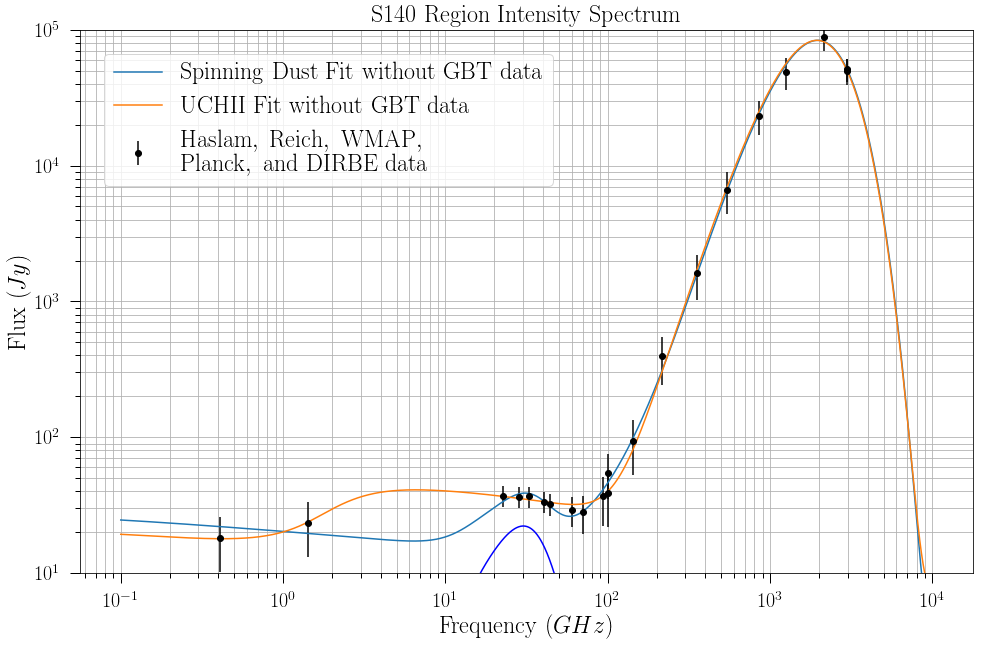

In [39]:
figure(figsize=(16,10))
plot(nu, signal(freqs, *pfit), label='$\mathrm{Spinning\ Dust\ Fit\ without\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit2), label='$\mathrm{UCHII\ Fit\ without\ GBT\ data}$')
#plot(nu, signal3(freqs, *pfit5), label='$\mathrm{No\ AME\ Model}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko',\
         label='$\mathrm{Haslam,\ Reich,\ WMAP,}$\n$\mathrm{Planck,\ and\ DIRBE\ data}$')

plot(nu, ame0, 'blue', alpha=1)
#plot(nu, ame0a, 'blue', alpha=1, ls='dashed', dashes=(3,5))

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency}\ (GHz)$')
ylabel('$\mathrm{Flux}\ (Jy)$')
legend(loc=2, ncol=1)
grid()
ylim(10, 1e5)
grid(which='minor')
title('$\mathrm{S140\ Region\ Intensity\ Spectrum}$')
#savefig('../notebooks/fullspectrum_withoutgbt')

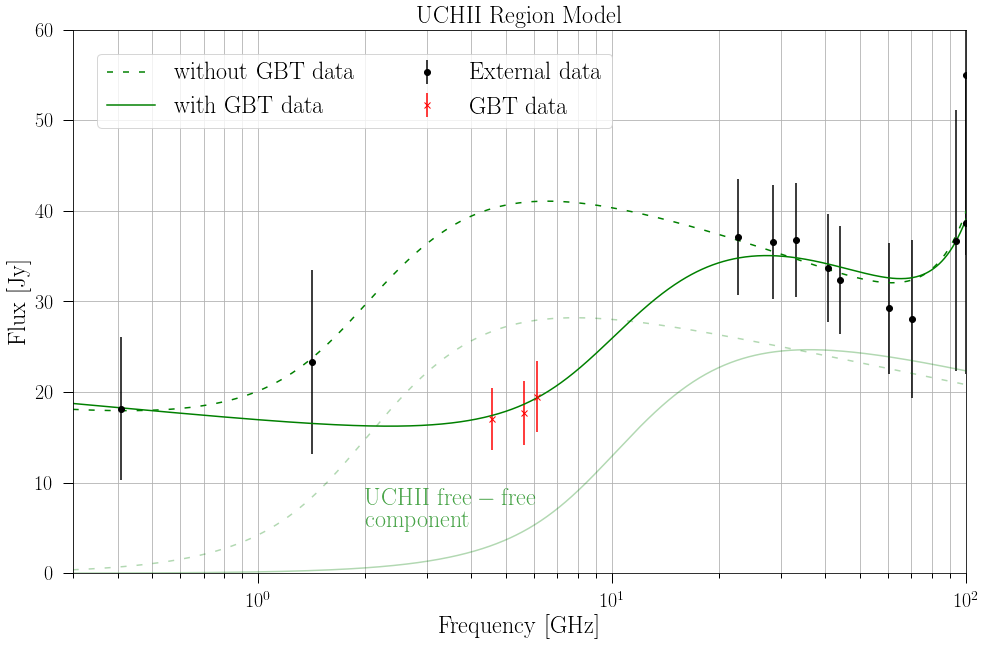

In [68]:
figure(figsize=(16,10))
plot(nu, signal2(freqs, *pfit2), 'green', ls='dashed', dashes=(3,5), label='$\mathrm{without\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit4), 'green', label='$\mathrm{with\ GBT\ data}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko', label='$\mathrm{External\ data}$')
errorbar(nfreqs*1.e-9, newdata, yerr=nerrs, fmt='rx', label='$\mathrm{GBT\ data}$')

alpha = 0.3
#plot(nu, ff1, 'green', alpha=alpha)
plot(nu, ff2, 'green', alpha=alpha)

#plot(nu, ff1a, 'green', alpha=alpha, ls='dashed', dashes=(3,5))
plot(nu, ff2a, 'green', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 100)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=2)
grid()
grid(which='minor')
xticks(fontsize=20)
yticks(fontsize=20)
text(2, 5, '$\mathrm{UCHII\ free-free}$\n $\mathrm{component}$', fontsize=24, color='green', alpha=0.7)
title('$\mathrm{UCHII\ Region\ Model}$')
savefig('../notebooks/freefreefit.pdf', format='pdf')

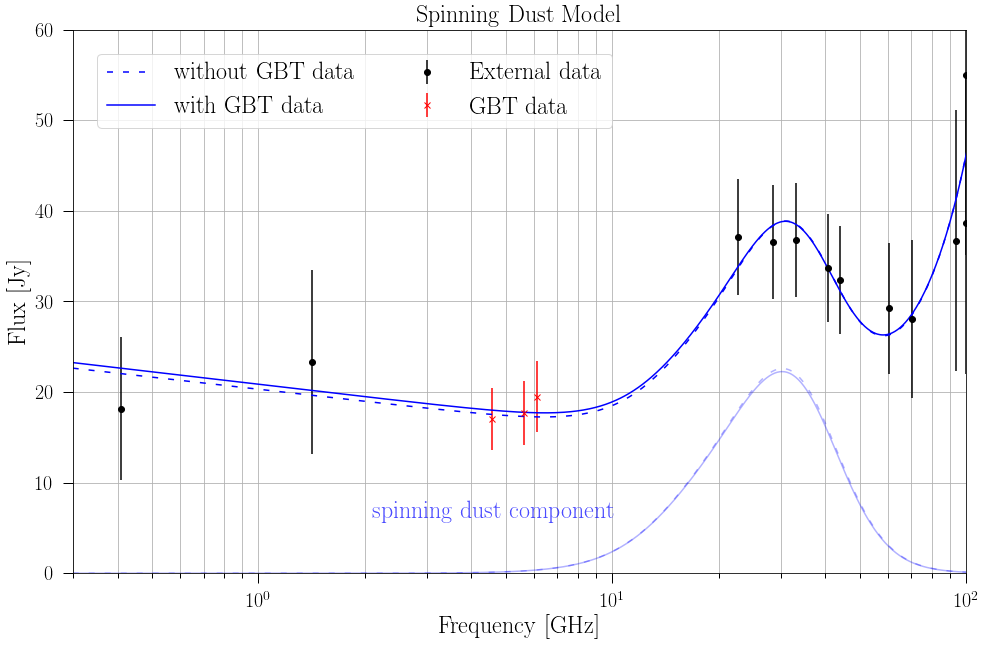

In [70]:
figure(figsize=(16,10))
plot(nu, signal(freqs, *pfit), 'blue', ls='dashed', dashes=(3,5), label='$\mathrm{without\ GBT\ data}$')
plot(nu, signal(freqs, *pfit3), 'blue', label='$\mathrm{with\ GBT\ data}$')
errorbar(cfs*1.e-9, cjys, yerr=cerrs, fmt='ko', label='$\mathrm{External\ data}$')
errorbar(nfreqs*1.e-9, newdata, yerr=nerrs, fmt='rx', label='$\mathrm{GBT\ data}$')

alpha = 0.3
#plot(nu, ff0, 'blue', alpha=alpha)
plot(nu, ame0, 'blue', alpha=alpha)
#plot(nu, cmb0, 'blue', alpha=alpha)

#plot(nu, ff0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))
plot(nu, ame0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))
#plot(nu, cmb0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 100)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=2)
grid()
grid(which='minor')
xticks()
yticks()
title('$\mathrm{Spinning\ Dust\ Model}$')
text(2.1, 6, '$\mathrm{spinning\ dust\ component}$', fontsize=24, color='blue', alpha=0.7)
savefig('../notebooks/spinningdustfit.pdf', format='pdf')